# Demo: Classifying audio data with an AudioDataLoader

## System setup

There are a few system libraries and python packages required to work with audio. If needed, uncomment and run this cell. In theory it should run OK even if you've already installed everything, but I think the `python setup.py install` step can complain if you've already built torchaudio.

Note that the cell returns an error code whether there's an error or not. This seems to be due to jupyter's shell command handling. You'll need to read the outputs in the cell to determine whether anything actually went wrong - sorry!

In [1]:
# %%bash
# set -m
# pip install pydub librosa --user
# sudo apt-get --assume-yes install ffmpeg sox libsox-dev libsox-fmt-all
# git clone https://github.com/pytorch/audio.git torchaudio
# cd torchaudio
# python setup.py install
# %%

<span style="color:red">**Don't forget to restart your notebook kernel after you've installed these modules!**</span> 

### fastai default setup

In [2]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/python dependencies. You might need to re-run the "System setup" cell again.

In [4]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

## The Audio Databunch Class

Defining the `AudioDataBunch`, `AudioList`, and `AudioItem` classes, which extend the base fastai `DataBunch`, `ItemList` and `ItemBase` objects to support audio in a first-class way. This originally from [
John Hartquist](https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89), and now in development from a few others.

Depending on how this library & the tutorials come together, we will need to change this definition - and the following implementation in the rest of the notebook (particularly around how the melspectrograms and transforms are handled).

This section won't be needed once these classes are really in the fastai library! 

In [5]:
class AudioDataBunch(DataBunch):
    def hear_ex(self, rows:int=3, ds_type:DatasetType=DatasetType.Valid, **kwargs):
        batch = self.dl(ds_type).dataset[:rows]
        self.train_ds.hear_xys(batch.x, batch.y, **kwargs)

# These are valid file extensions for audio files
AUDIO_EXTENSIONS = set(k for k,v in mimetypes.types_map.items() if v.startswith('audio/'));

class AudioList(ItemList):
    _bunch = AudioDataBunch
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
            
    def get(self, i): return AudioItem.open(self.items[i])
    
    def reconstruct(self, t:Tensor): return Image(t.transpose(1,2))

    def hear_xys(self, xs, ys, **kwargs):
        for x, y in zip(xs, ys): x.hear(title=y, **kwargs)

    @classmethod
    def from_folder(cls, path:PathOrStr='.', extensions:Collection[str]=None, **kwargs)->ItemList:
        extensions = ifnone(extensions, AUDIO_EXTENSIONS)
        return super().from_folder(path=path, extensions=extensions, **kwargs)

class AudioItem(ItemBase):
    def __init__(self, fn, data=None, **kwargs):
        sig,sr = torchaudio.load(fn)
        self.fn = fn
        self.signal = sig
        self.data,self.sr,self.kwargs = data,sr,kwargs
        if self.data is None: self.data = transforms.MelSpectrogram(sr=sr, **kwargs)(self.signal)

    def __str__(self): return f'Duration: {self.duration} seconds. Source: {self.fn}'
    def __len__(self): return self.signal.shape[1]
    def _repr_html_(self): return f'{self.__str__()}<br />{self.ipy_audio._repr_html_()}'
    
    def show(self, title:Optional[str]=None, **kwargs):
        "Show sound on `ax` with `title`, using `cmap` if single-channel, overlaid with optional `y`"
        self.hear(title=title)

    def hear(self, title=None):
        if title is not None: print(title)
        display(self.ipy_audio)

    def apply_tfms(self, tfms):
        for tfm in tfms:
            self.data = tfm(self.data)
        return self
        
    @property
    def shape(self):
        return self.data.shape

    @property
    def size(self)->Tuple[int,int]: return self.data.shape[-2:]

    @property
    def ipy_audio(self): return Audio(data=self.signal, rate=self.sr)

    @property
    def duration(self): return len(self)/self.sr

    @classmethod
    def open(cls, fn, **kwargs):
        return AudioItem(fn)

## Preparing the data

We're going to do **speaker identification** with [the Free ST American English Corpus](http://www.openslr.org/45/ ) data. It's a small-enough, freely-available dataset. 

Note that we started using the [TIMIT dataset](https://catalog.ldc.upenn.edu/LDC93S1), but the copyright isn't clear, and the data is hard to download. The best option was [this github readme](https://github.com/philipperemy/timit) which pointed to [this AcademicTorrents link](http://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3) but A) nuts to downloading torrents and B) not sure about licensing given LDC charges a fee.

### Download

This step is a bit more complex than expected because A) the fastai `untar_data` function doesn't accept a filename with a .tgz extension (it adds it itself) and B) the .tgz file we're using doesn't extract itself into its own directory (sigh). 

In [6]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))

In [7]:
untar_data(data_url, dest = data_folder)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

Did we get anything?

In [8]:
data_folder.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav')]

Hurray!

Sanity check - play a file just using torchaudio.

In [9]:
sig,sr = torchaudio.load(data_folder.ls()[0])
Audio(data=sig, rate=sr)

### Load into a DataBunch

Here we'll load our audio data in an idiomatic to fastai way. 

First we make an AudioList of our downloaded data.

In [11]:
audios = AudioList.from_folder(data_folder); audios

AudioList (3842 items)
Duration: 3.28 seconds. Source: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,Duration: 4.4 seconds. Source: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,Duration: 5.32 seconds. Source: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,Duration: 3.36 seconds. Source: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,Duration: 3.8 seconds. Source: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav
Path: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS

We'll need to put these into an AudioDataBunch. However, a DataBunch expects all members of its collection to be the same size, so that they can be successfully batched together. Just by eyeballing the result of the previous cell, it looks like our audio clips aren't all the same length. Let's check.

(array([135., 676., 998., 844., 603., 313., 132.,  69.,  52.,  20.]),
 array([132. , 198.9, 265.8, 332.7, 399.6, 466.5, 533.4, 600.3, 667.2, 734.1, 801. ]),
 <a list of 10 Patch objects>)

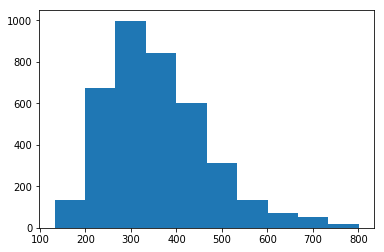

In [12]:
audio_lengths = tensor([a.data.shape[1] for a in audios])
plt.hist(audio_lengths)

OK, so they're not all of the same length. The distribution isn't too bad though, i.e. they're not _too_ different. We'll just deal with this in a brute force way - 0-pad them to  be the same length as the longest sample. 

We'll do this with a simple dataset transform to 0-pad the samples to the length of the max sample. 

Keep in mind - this is a bit tricky. In this iteration of AudioItem, each AudioItem's `data` is going to be set to a melspectrogram of the waveform, not the signal data itself. So what we're going to need to do is 0-pad the waveform data before we create the melspectrogram. That way, the `item.data` property will contain equal-sized melspectrograms. This will leave the waveform signal information untouched in the object's `.signal` property.

Here's how we're going to do the padding.

In [13]:
# Get longest audio clip
max_len_of_audio = audio_lengths.max()

def _pad_to_max(mx, value, t):
    """Pad tensor with `value` until it reaches length `mx`"""
    if t.shape[1] == mx: return t
    return F.pad(t, (0,0, 0,mx-t.shape[1]), value=value)

# Get a transform function that uses the max length of our audio list and pads with silence (0)
pad_to_max = partial(_pad_to_max, max_len_of_audio, 0)

Now (finally) let's load the data into a DataBunch.

We're doing speaker recognition, which is a classification problem. Our labels are speaker IDs. These speaker IDs are in the filenames - e.g. in the filename `f0005_us_f0005_00286`, the speaker ID is `f0005`. We'll use the `label_from_re` function to tell the DataBunch how to get our labels. 

In [14]:
## Regex to get the speaker ID in our file name (our label)
label_pattern = r'_([mf]\d+)_'

# Normal datablock setup from our AudioList from above.
data = (audios
        .split_by_rand_pct(0.2)
        .label_from_re(label_pattern)
        .transform([[pad_to_max], [pad_to_max]])
        .databunch())

### Basic sanity checking

In [15]:
f"Found {data.c} classes, \
{len(data.train_ds)} training samples,\
{len(data.valid_ds)} validation samples"

'Found 10 classes, 3074 training samples,768 validation samples'

In [16]:
data.hear_ex()

f0004


m0002


m0003


In [17]:
## Sadly, this doesn't work yet. Todo: make this work!
# data.show_batch()

## Modeling

Now we're ready to model it! From now on, this is almost exactly the same as a typical fastai image classification workflow, with one small difference. We'll classify our images using Resnet18. Resnet expects a 3 channel input (RGB values for an image).

Our data has only 1 channel. So we'll replace the first layer of our ResNet with custom layer that's identical except it accepts 1 channel input.

In [18]:
newlayer = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
newlayer.cuda() # Our layer should use cuda, since the rest of the model will.

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [19]:
## Standard learner
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

## Replace the first layer in the resnet18 model with our first layer
learn.model[0][0] = newlayer

In [20]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.851106,1.287811,0.536458,00:22
1,1.158848,0.602680,0.794271,00:16
2,0.750583,0.466023,0.841146,00:17
3,0.531941,0.416480,0.861979,00:16
4,0.413091,0.430601,0.855469,00:17


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


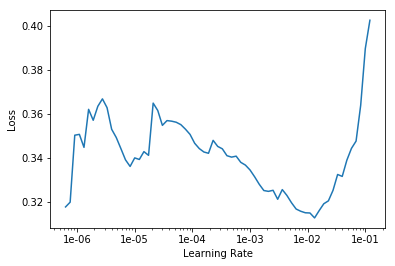

In [21]:
lr_find(learn)
learn.recorder.plot()

**Don't forget** to update the learning rate parameter below according to what you see in the chart above!

epoch,train_loss,valid_loss,accuracy,time
0,0.325222,0.406596,0.864583,00:17
1,0.345363,0.414728,0.864583,00:17
2,0.325204,0.410763,0.861979,00:17
3,0.329908,0.406446,0.856771,00:17
4,0.321512,0.399988,0.860677,00:17
5,0.322412,0.397375,0.861979,00:16
6,0.334092,0.413734,0.850260,00:17
7,0.332408,0.395486,0.861979,00:17
8,0.329254,0.394984,0.864583,00:16
9,0.321675,0.391145,0.859375,00:17


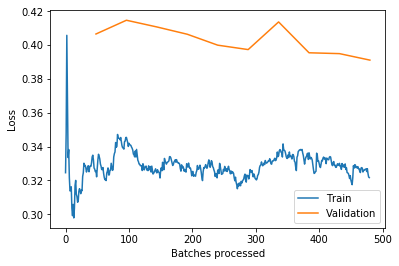

In [22]:
learn.fit_one_cycle(10, 1e-05)
learn.recorder.plot_losses()

### Interpret the results

All done! The results look OK at ~84% accuracy, but we can probably do better. We can do some basic examination of our results to try to get a feeling for where it might be going wrong.
Based on what we see here, we can go back and tweak the model accordingly later.

In [23]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

m0004/f0005 / 19.14 / 0.00


m0001/f0004 / 5.33 / 0.00


f0002/f0005 / 4.97 / 0.01


f0005/f0001 / 4.83 / 0.01


m0005/f0005 / 4.73 / 0.01


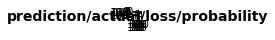

In [24]:
interp.plot_top_losses(5, figsize=(0.1,0.1))

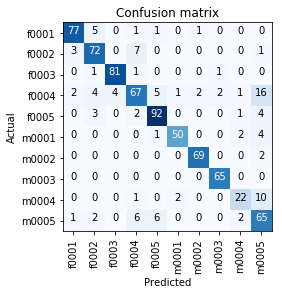

In [25]:
interp.plot_confusion_matrix()

## Fin.